In [1]:
# %%
# Imports
from base64 import decode
from config import ds_config
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
import torchvision.transforms.functional as transformF

# from fastai.callback.tracker import
from fastai.vision.widgets import *
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import argparse as ap
import datetime
import gc
from tqdm import tqdm
# from torch.multiprocessing import set_start_method
# set_start_method('forkserver')

# from torch.multiprocessing import Pool, Process, set_start_method
# try:
#      set_start_method('spawn')
# except RuntimeError:
#     pass

from utils import *  # import utils at the end after fastai because the Hook function is a monkey-patch

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# set_start_method('spawn')
# Monkey patch batch prediction (fastai does not have this by default)
Learner.predict_batch = predict_batch
# %%
# ags = ap.ArgumentParser("Additional Arguments for CLI")
# ags.add_argument(
#     "--config", help="Name of config from dictionary", default="fish_test_proxy"
# )
# ags.add_argument("--name", help="Name of the experiment", required=True)
# args = ags.parse_args()
# ds_meta = ds_config[args.config]  # get info about dataset from the config file

args = {
    "config": "fish_test_proxy",
    "name" : "testing_ugh"
}
from types import SimpleNamespace
args = SimpleNamespace(**args)
ds_meta = ds_config[args.config]  # get info about dataset from the config file

In [2]:
path = Path(ds_meta["ds_path"])
fname_start = f'{ds_meta["ds_name"]}_{args.name}_{datetime.now().strftime("%d%m%Y_%H:%M:%S")}'  # unique_name
print(f"[INFO] : File name = {fname_start}")

# Check if directories all present
create_if_not_exists(f"tb_runs/{fname_start}")
create_if_not_exists(f"csv_logs/{fname_start}")
# Remove previous files

all_files = get_image_files(path)
[Path.unlink(file) for file in all_files if "augmented_" in file.name]
print("[INFO] : Removed Old augmented files")

# TODO : Add reset folder
#%%
batch_tfms = aug_transforms() if ds_meta["enable_default_augments"] == True else None
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=ds_meta["name_fn"],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(ds_meta["image_size"], min_scale=0.5),
    batch_tfms=batch_tfms,
)
# Metrics
metrics = [accuracy, error_rate]
# Callbacks


[INFO] : File name = fish_testing_ugh_17102022_15:20:29
[INFO] : Removed Old augmented files


# Train Round 1

In [3]:
dls = fields.dataloaders(path, bs=ds_meta["batch_size"])
cbs = [
TensorBoardCallback(
    log_dir=f"tb_runs/{fname_start}", projector=False, trace_model=False
),
CSVLogger(fname=f"csv_logs/{fname_start}.csv"),
]

learn = vision_learner(
dls, ds_meta["network"], cbs=cbs, metrics=metrics, pretrained=ds_meta["pretrained"]
).to_fp16()
fname_training = f'{ds_meta["ds_name"]}_{args.name}_{datetime.now().strftime("%d%m%Y_%H:%M:%S")}'  # unique_name
# learn.fine_tune(1)
# learn.save("temp_model")  # saving so can be reloaded
learn.load("temp_model")
# clear_learner(learn, dls)
print("[LOG] : Cleared learner")


/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[LOG] : Cleared learner


In [330]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    # Automatically register the hook when entering it
    def __enter__(self, *args): return self
    # Automatically remove the hook when exiting it
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

# dls.to('cpu')

# Get the classes
print("[INFO] : Starting Attention Loop")
vocab_dict = {
learn.dls.vocab[x]: x for x in range(len(learn.dls.vocab))
}  # Get class names
# Get images, shuffle, pick a subset
items = get_image_files_exclude_augment(ds_meta["ds_path"])
items = items.shuffle()
subset = int(ds_meta["change_subset_attention"] * len(items))
items = items[:subset]
# Get preds from the network for all the chosen images with "num_workers" threads
bspred = learn.predict_batch(items, num_workers=10)
# Get all the class names for the subset of images and convert them into the One hot encoded version that the network knows already
item_names = list(
map(lambda x: vocab_dict[x], list(map(ds_meta["name_fn"], items)))
)

# Get the index of all the images that the network predicted wrong
# TODO : Check for confidence
index_wrongs = [
x for x in range(subset) if bspred[2][x] != TensorBase(item_names)[x]
]

[INFO] : Starting Attention Loop


In [331]:
ims = [items[x] for x in tqdm(index_wrongs, total = len(index_wrongs))]
test_ds_new_ims = dls.test_dl(ims, bs = 16)

100%|██████████| 50/50 [00:00<00:00, 196178.86it/s]


In [332]:
preds = learn.get_preds(dl = test_ds_new_ims, with_decoded=True)[2]

In [333]:
def generate_batch(lst, batch_size):
    """  Yields batch of specified size """
    return [lst[i : i + batch_size] for i in range(0, len(lst), batch_size)]


In [360]:
# to_check = learn.model[-2][4][-1]
# learn.eval()

item_names_batched = generate_batch(item_names, test_ds_new_ims.bs)

cam_maps = []
for i, data in tqdm(enumerate(test_ds_new_ims)):

    data = dls.train.decode(data)
    y_values = item_names_batched[i]

    with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
        with Hook(learn.model[-2][4][-1]) as hook:
            preds = learn.model.eval()(data[0].float().to("cuda"))
            # print(len(preds))
            # acts = hook.stored
            act = hook.stored
        
        # THIS is the issue I think.
        for i_2 in range(len(preds)):
            preds[i_2,y_values[i_2]-1].backward(retain_graph = True)
        grad = hookg.stored
        for i in grad:
          print(i.sum())
    for i_3 in range(len(preds)):
        w = grad[i_3].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[i_3]).sum(0)
        # print(w.sum())
        cam_maps.append(cam_map)
    break

    #     preds[0, 3].backward()
    #     grad = hookg.stored
    # w = grad[0].mean(dim=[1, 2], keepdim=True)
    # cam_map = (w * act[0]).sum(0)
    # cam_maps.append(cam_map)

    #     for i_2, output_x in tqdm(enumerate(preds), total = len(preds)):
    #         preds[i_2, y_values[i_2]].backward(retain_graph = True)
    #     grads = hookg.stored
    #     # print(grads[0].shape, acts[0].shape)
    # for i_3, output_x in tqdm(enumerate(grads), total = len(grads)):
    #     w = grads[i_3].mean(dim=[1, 2], keepdim=True)
    #     # w = grads[i_3]
    #     cam_map = (w * acts[i_3]).sum(0)
    #     cam_maps.append(cam_map)

0it [00:00, ?it/s]/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
0it [00:00, ?it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(-9.8628, device='cuda:0')


In [353]:
grad.shape

torch.Size([16, 64, 56, 56])

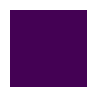

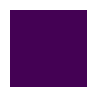

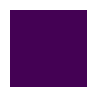

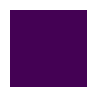

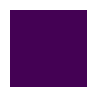

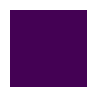

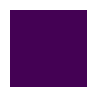

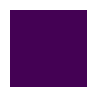

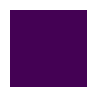

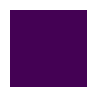

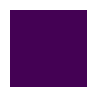

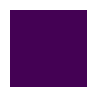

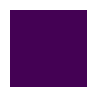

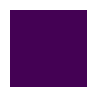

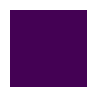

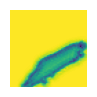

In [354]:
for i in range(len(cam_maps)):
    show_image(cam_maps[i])

In [131]:
print("Resizing")
t_resized = [transformF.resize(torch.unsqueeze(cam_map, 0), ds_meta["image_size"]) for cam_map in cam_maps]
t_resized = [torch.cat([x, x, x], dim=0).detach().cpu() for x in t_resized]
t_resized_batch = generate_batch(t_resized, test_ds_new_ims.bs)

decoded_tensor_images = dls.train.decode(data)
# decoded_tensor_images = [dls.train.decode(x)[0][0].float() for x in tqdm(test_ds_new_ims, total = len(test_ds_new_ims))]


Resizing


In [149]:
decoded_tensor_images[0].shape

torch.Size([3, 3, 224, 224])

In [144]:
print(len(t_resized_batch), len(decoded_tensor_images))

5 1


In [143]:
for batch in range(len(t_resized_batch)):
    for index in range(len(t_resized_batch[batch])):
        print(decoded_tensor_images[batch][index].shape, t_resized_batch[batch][index].shape)
        decoded_tensor_images[batch][index][t_resized_batch[batch][index] >=0.009] = 0.0
        # decoded_tensor_images[batch][index] = torch.einsum("ijk->jki", decoded_tensor_images[batch][index])
    

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


IndexError: index 3 is out of bounds for dimension 0 with size 3

In [31]:
ims = [PILImage.create(items[x]) for x in tqdm(index_wrongs, total = len(index_wrongs))]
im_names = [items[x] for x in index_wrongs]
test_ds_new_ims = dls.test_dl(ims, shuffle = False)
decoded = [dls.train.decode(x)[0].float() for x in tqdm(test_ds_new_ims, total = len(test_ds_new_ims))]
eval_model =learn.model.eval() 
# eval_model_results = [eval_model(first(x).float().cuda()) for x in test_ds_new_ims]
# eval_model_results = learn.predict_batch(ims)[0]
# print(eval_model_results)
# Hook
cls = 1
cam_maps = []

print("Creating map")
for im in tqdm(decoded, total = len(decoded)):
    with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
        with Hook(learn.model[-2][4][-1]) as hook:
            output = eval_model(im.cuda())
            print(output.shape)
            # output = learn.predict(im)
            act = hook.stored
        output[0, cls].backward()
        grad = hookg.stored
    w = grad[0].mean(dim=[1, 2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    cam_maps.append(cam_map)
    break

# print("Resizing")
# t_resized = [transformF.resize(torch.unsqueeze(cam_map, 0), ds_meta["image_size"]) for cam_map in cam_maps]
# t_resized = [torch.cat([x, x, x], dim=0).detach().cpu() for x in t_resized]
# decoded_tensor_images = [dls.train.decode(x)[0][0].float() for x in tqdm(test_ds_new_ims, total = len(test_ds_new_ims))]

# for ind in tqdm(range(len(t_resized))):
#     decoded_tensor_images[ind][t_resized[ind] >=0.009] = 0.0
#     decoded_tensor_images[ind] = torch.einsum("ijk->jki", decoded_tensor_images[ind])

# for ind in tqdm(range(len(decoded_tensor_images))):
#     plt.imshow(decoded_tensor_images[ind])
#     plt.axis("off")
#     ax=plt.gca()
#     ax.get_xaxis().set_visible(False)
#     plt.box(False)
#     plt.savefig(rename_for_aug(im_names[ind]), transparent = True, bbox_inches='tight',pad_inches = 0)
# clear_learner(learn, dls)
# del bspred
# del items
# # del t_resized
# gc.collect()


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Creating map


  0%|          | 0/1 [00:00<?, ?it/s]/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([69, 18])
